Importing libararies which are used in project

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns
import time
from scipy.stats import chi2_contingency
%matplotlib inline

# Importing data

In [8]:
# Load datasets
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
weather_data = pd.read_csv('/content/drive/My Drive/Weather Dataset 2022.csv')
print(weather_data.head())

         date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
0  2022-01-01   9.7   6.4  11.6  24.0   NaN   150   7.8   NaN  1008.1   NaN
1  2022-01-02   9.1   1.8  13.4   5.2   NaN   315  15.7   NaN  1005.6   NaN
2  2022-01-03  -1.9  -4.6   1.3   2.5   NaN     1  22.7   NaN  1019.4   NaN
3  2022-01-04  -2.8  -6.2   0.8   0.0   NaN   270  11.1   NaN  1028.1   NaN
4  2022-01-05   3.0  -1.5   7.9   3.3   NaN   224  13.3   NaN  1014.3   NaN


In [10]:
turnstile_data = pd.read_csv('/content/drive/My Drive/MTA_Subway_Turnstile_Data_2022.csv')
print(turnstile_data.head())

    C/A  Unit       SCP Line Name Division        Date      Time Description  \
0  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  03:00:00     REGULAR   
1  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  07:00:00     REGULAR   
2  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  11:00:00     REGULAR   
3  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  15:00:00     REGULAR   
4  A002  R051  02-00-00   NQR456W      BMT  12/30/2022  19:00:00     REGULAR   

   Entries  Exits                                                       
0  7811029                                            2770909           
1  7811032                                            2770930           
2  7811067                                            2771080           
3  7811217                                            2771126           
4  7811477                                            2771174           


In [11]:
# Randomly sample rows without replacement
turnstile_data = turnstile_data.sample(n=500000, random_state=42)
print("Data reduced")

Data reduced


In [12]:
# Clean turnstile data
turnstile_data.columns = turnstile_data.columns.str.strip()
turnstile_data.rename(columns={'Entries': 'ENTRIES', 'Exits': 'EXITS'}, inplace=True)
print(turnstile_data.head())

           C/A  Unit       SCP Line Name Division        Date      Time  \
9859018   H007  R248  00-00-01         L      BMT  02/06/2022  15:00:00   
9241920  PTH18  R549  01-00-08         1      PTH  02/27/2022  07:47:30   
4754825   R180  R193  00-00-04         1      IRT  07/26/2022  09:00:00   
8613796  PTH09  R548  00-00-03         1      PTH  03/20/2022  03:26:04   
7655829   R407  R448  01-00-01         6      IRT  04/21/2022  01:00:00   

        Description   ENTRIES     EXITS  
9859018     REGULAR  61525710  38873935  
9241920     REGULAR    112036      5845  
4754825     REGULAR      4726     13908  
8613796     REGULAR     74413     74220  
7655829     REGULAR    253165    673284  


In [13]:
# Calculate daily entries and exits
turnstile_data['Date'] = pd.to_datetime(turnstile_data['Date'])
turnstile_data = turnstile_data.sort_values(by=['C/A', 'Unit', 'SCP', 'Date', 'Time'])
turnstile_data['Daily Entries'] = turnstile_data.groupby(['C/A', 'Unit', 'SCP'])['ENTRIES'].diff().fillna(0)
turnstile_data['Daily Exits'] = turnstile_data.groupby(['C/A', 'Unit', 'SCP'])['EXITS'].diff().fillna(0)

In [14]:
# Filter out negative values
turnstile_data = turnstile_data[(turnstile_data['Daily Entries'] >= 0) & (turnstile_data['Daily Exits'] >= 0)]

In [15]:
# Remove outliers using IQR for 'Daily Entries' and 'Daily Exits'
Q1 = turnstile_data[['Daily Entries', 'Daily Exits']].quantile(0.25)
Q3 = turnstile_data[['Daily Entries', 'Daily Exits']].quantile(0.75)
IQR = Q3 - Q1

In [16]:
# Keep rows within 1.5*IQR range
turnstile_data = turnstile_data[~((turnstile_data[['Daily Entries', 'Daily Exits']] < (Q1 - 1.5 * IQR)) |(turnstile_data[['Daily Entries', 'Daily Exits']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [17]:
print(f"Data shape before outlier removal: {turnstile_data.shape}")

Data shape before outlier removal: (424845, 12)


In [18]:
#Changed the date to date format (y-m-d)
weather_data['date'] = pd.to_datetime(weather_data['date'], format='%Y-%m-%d')

In [19]:
# Merge the datasets on the date
data = pd.merge(turnstile_data, weather_data, left_on='Date', right_on='date', how='left')


In [20]:
data.isnull().sum()

,0
C/A,0
Unit,0
SCP,0
Line Name,0
Division,0
Date,0
Time,0
Description,0
ENTRIES,0
EXITS,0


In [21]:
# Drop columns that are entirely NaN in merged data
data = data.drop(columns=['snow', 'wpgt', 'tsun','date'], errors='ignore')

In [22]:
data.isnull().sum()

,0
C/A,0
Unit,0
SCP,0
Line Name,0
Division,0
Date,0
Time,0
Description,0
ENTRIES,0
EXITS,0


# Data Cleaning

In [23]:
data.columns

Index(['C/A', 'Unit', 'SCP', 'Line Name', 'Division', 'Date', 'Time',
       'Description', 'ENTRIES', 'EXITS', 'Daily Entries', 'Daily Exits',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'],
      dtype='object')

In [24]:
# number of unique value in each variable
data.nunique()

,0
C/A,753
Unit,470
SCP,228
Line Name,114
Division,6
Date,364
Time,23461
Description,2
ENTRIES,357416
EXITS,344184


In [25]:
data = data.drop(data[data['Daily Entries'].isnull()].index, axis=0)
data.shape

(424845, 19)

In [26]:
data.isnull().sum()

,0
C/A,0
Unit,0
SCP,0
Line Name,0
Division,0
Date,0
Time,0
Description,0
ENTRIES,0
EXITS,0


Converting Categorical Columns

In [27]:
#Assigning levels to the categories
#Converting object type columns into categorical data for memory optimization
lis = []
for i in range(0, data.shape[1]):
    if(data.iloc[:,i].dtypes == 'object'):
        data.iloc[:,i] = pd.Categorical(data.iloc[:,i])
        #data.iloc[:,i] = data.iloc[:,i].cat.codes
        data.iloc[:,i] = data.iloc[:,i].astype('object')
        lis.append(data.columns[i])


In [28]:
lis

['C/A', 'Unit', 'SCP', 'Line Name', 'Division', 'Time', 'Description']

In [29]:
data.head(20)

,C/A,Unit,SCP,Line Name,Division,Date,Time,Description,ENTRIES,EXITS,Daily Entries,Daily Exits,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,A002,R051,02-00-00,NQR456W,BMT,2022-01-09,23:00:00,REGULAR,7677647,2652319,0.0,0.0,1.5,-4.5,5.0,3.2,225,17.6,1023.1
1,A002,R051,02-00-00,NQR456W,BMT,2022-01-11,15:00:00,REGULAR,7677977,2653100,330.0,781.0,-7.2,-9.3,-4.8,0.0,336,18.1,1031.2
2,A002,R051,02-00-00,NQR456W,BMT,2022-01-14,07:00:00,REGULAR,7678730,2654142,753.0,1042.0,1.3,-6.1,5.4,0.0,359,24.2,1009.8
3,A002,R051,02-00-00,NQR456W,BMT,2022-01-19,11:00:00,REGULAR,7679769,2655883,1039.0,1741.0,2.3,-4.8,7.5,0.0,206,16.8,1018.4
4,A002,R051,02-00-00,NQR456W,BMT,2022-01-20,15:00:00,REGULAR,7680121,2656380,352.0,497.0,-0.1,-7.5,4.2,7.8,315,18.1,1021.6
5,A002,R051,02-00-00,NQR456W,BMT,2022-01-21,23:00:00,REGULAR,7680597,2656947,476.0,567.0,-8.7,-12.1,-5.2,0.0,2,20.2,1033.2
6,A002,R051,02-00-00,NQR456W,BMT,2022-02-01,03:00:00,REGULAR,7682954,2660457,2357.0,3510.0,-3.2,-12.3,4.4,0.0,34,13.0,1034.0
7,A002,R051,02-00-00,NQR456W,BMT,2022-02-02,11:00:00,REGULAR,7683283,2661237,329.0,780.0,4.1,1.1,8.3,0.0,36,8.6,1030.6
8,A002,R051,02-00-00,NQR456W,BMT,2022-02-10,07:00:00,REGULAR,7685531,2664406,2248.0,3169.0,7.4,3.9,12.2,0.1,268,12.0,1012.2
9,A002,R051,02-00-00,NQR456W,BMT,2022-02-11,03:00:00,REGULAR,7685831,2664909,300.0,503.0,8.3,-1.2,13.3,0.0,230,8.2,1014.8


In [30]:
#Convert into proper datatypes
for i in lis:
    data.loc[:,i] = data.loc[:,i].round()
    data.loc[:,i] = data.loc[:,i].astype('object')

In [31]:
data.head()

,C/A,Unit,SCP,Line Name,Division,Date,Time,Description,ENTRIES,EXITS,Daily Entries,Daily Exits,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,A002,R051,02-00-00,NQR456W,BMT,2022-01-09,23:00:00,REGULAR,7677647,2652319,0.0,0.0,1.5,-4.5,5.0,3.2,225,17.6,1023.1
1,A002,R051,02-00-00,NQR456W,BMT,2022-01-11,15:00:00,REGULAR,7677977,2653100,330.0,781.0,-7.2,-9.3,-4.8,0.0,336,18.1,1031.2
2,A002,R051,02-00-00,NQR456W,BMT,2022-01-14,07:00:00,REGULAR,7678730,2654142,753.0,1042.0,1.3,-6.1,5.4,0.0,359,24.2,1009.8
3,A002,R051,02-00-00,NQR456W,BMT,2022-01-19,11:00:00,REGULAR,7679769,2655883,1039.0,1741.0,2.3,-4.8,7.5,0.0,206,16.8,1018.4
4,A002,R051,02-00-00,NQR456W,BMT,2022-01-20,15:00:00,REGULAR,7680121,2656380,352.0,497.0,-0.1,-7.5,4.2,7.8,315,18.1,1021.6


In [32]:
data.shape

(424845, 19)

In [33]:
data.dtypes

,0
C/A,object
Unit,object
SCP,object
Line Name,object
Division,object
Date,datetime64[ns]
Time,object
Description,object
ENTRIES,int64
EXITS,int64


In [34]:
data.describe()

,Date,ENTRIES,EXITS,Daily Entries,Daily Exits,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,424845,4.248450e+05,4.248450e+05,424845.000000,424845.000000,424845.000000,424845.000000,424845.000000,424845.000000,424845.000000,424845.000000,424845.000000
mean,2022-06-29 17:41:01.391801856,2.628490e+07,1.988239e+07,788.426549,983.609542,12.998966,9.169365,17.243003,3.146563,207.514861,12.003353,1017.807532
min,2022-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,-10.700000,-16.100000,-6.500000,0.000000,1.000000,4.300000,989.700000
25%,2022-03-30 00:00:00,2.099460e+05,1.052980e+05,81.000000,83.000000,5.100000,1.100000,8.900000,0.000000,116.000000,8.400000,1013.400000
50%,2022-06-30 00:00:00,1.092075e+06,7.187730e+05,427.000000,499.000000,13.300000,9.400000,17.700000,0.200000,249.000000,10.800000,1017.600000
75%,2022-09-29 00:00:00,5.352741e+06,3.216739e+06,1172.000000,1443.000000,21.400000,17.800000,25.900000,3.200000,278.000000,14.200000,1022.900000
max,2022-12-30 00:00:00,2.147336e+09,2.122529e+09,4175.000000,5385.000000,30.800000,26.700000,36.100000,71.400000,359.000000,31.800000,1037.300000
std,NaN,1.577042e+08,1.369495e+08,927.955939,1201.078070,9.837047,9.937494,10.095021,6.678160,101.440427,4.991566,7.352555


In [35]:
#replace -1 with NA to impute
for i in range(0, data.shape[1]):
    data.iloc[:,i] = data.iloc[:,i].replace(-1, np.nan)

In [36]:
data.dropna(inplace=True)
data.isnull().sum()

,0
C/A,0
Unit,0
SCP,0
Line Name,0
Division,0
Date,0
Time,0
Description,0
ENTRIES,0
EXITS,0


In [37]:
data.shape

(418831, 19)

In [38]:
print(data.dtypes)
data.columns

C/A                      object
Unit                     object
SCP                      object
Line Name                object
Division                 object
Date             datetime64[ns]
Time                     object
Description              object
ENTRIES                   int64
EXITS                     int64
Daily Entries           float64
Daily Exits             float64
tavg                    float64
tmin                    float64
tmax                    float64
prcp                    float64
wdir                      int64
wspd                    float64
pres                    float64
dtype: object


Index(['C/A', 'Unit', 'SCP', 'Line Name', 'Division', 'Date', 'Time',
       'Description', 'ENTRIES', 'EXITS', 'Daily Entries', 'Daily Exits',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres'],
      dtype='object')

In [39]:
#Categorizes columns for targeted analysis and processing
#Includes columns representing categorizes like C/A, Division, and Description.
categorical_vars =['C/A', 'Unit', 'SCP', 'Line Name', 'Division', 'Time','Description']
categorical_vars

['C/A', 'Unit', 'SCP', 'Line Name', 'Division', 'Time', 'Description']

In [40]:
#Includes numerical columns such as Daily Entries, tavg and prcp.
continuous_vars= ['ENTRIES', 'EXITS', 'Daily Entries', 'Daily Exits',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']
continuous_vars

['ENTRIES',
 'EXITS',
 'Daily Entries',
 'Daily Exits',
 'tavg',
 'tmin',
 'tmax',
 'prcp',
 'wdir',
 'wspd',
 'pres']

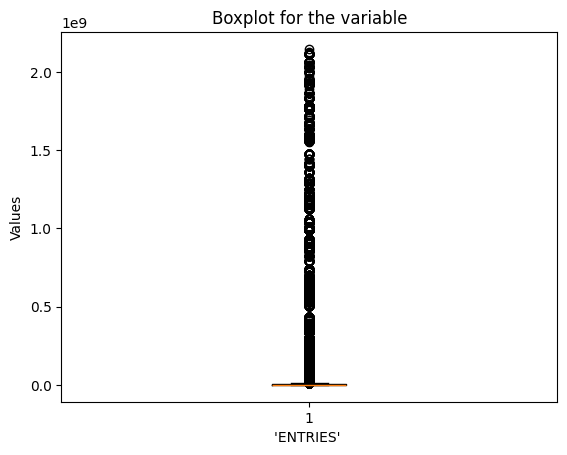

In [41]:
#To visualize distribution of ENTRIES variable and identify outliers.
plt.boxplot(data['ENTRIES'])
plt.xlabel("'ENTRIES' ")
plt.title("Boxplot for the variable")
plt.ylabel('Values')
plt.show()

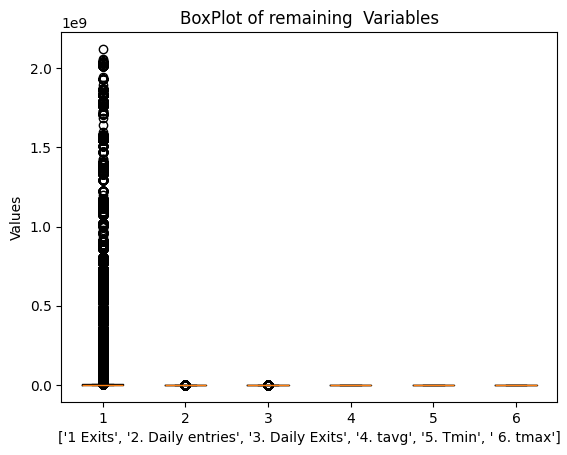

In [42]:
plt.boxplot([ data['EXITS'],  data['Daily Entries'], data[ 'Daily Exits'], data['tavg'], data['tmin'],data['tmax']])
plt.xlabel(['1 Exits', '2. Daily entries', '3. Daily Exits', '4. tavg', '5. Tmin',' 6. tmax'])
plt.title("BoxPlot of remaining  Variables")
plt.ylabel('Values')
plt.show()

# Correlation Analysis

In [43]:
#Correlation analysis measures the strength and direction of relationships between variables, helping to identify significant patterns.
#This code extracts only the continuos variables from the dataset to perform correlation analysis.
df_corr = data.loc[:,continuous_vars]
df_corr

,ENTRIES,EXITS,Daily Entries,Daily Exits,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,7677647,2652319,0.0,0.0,1.5,-4.5,5.0,3.2,225,17.6,1023.1
1,7677977,2653100,330.0,781.0,-7.2,-9.3,-4.8,0.0,336,18.1,1031.2
2,7678730,2654142,753.0,1042.0,1.3,-6.1,5.4,0.0,359,24.2,1009.8
3,7679769,2655883,1039.0,1741.0,2.3,-4.8,7.5,0.0,206,16.8,1018.4
4,7680121,2656380,352.0,497.0,-0.1,-7.5,4.2,7.8,315,18.1,1021.6
...,...,...,...,...,...,...,...,...,...,...,...
424839,0,1101,0.0,5.0,2.6,-1.6,5.8,9.1,39,23.4,1020.4
424840,0,1104,0.0,3.0,3.5,0.2,6.9,0.4,264,12.9,1007.7
424841,0,1104,0.0,0.0,0.1,-2.3,3.6,0.0,265,12.4,1023.7
424842,0,1106,0.0,2.0,-0.2,-2.6,3.3,0.0,308,7.2,1029.7


In [44]:
data.describe()

,Date,ENTRIES,EXITS,Daily Entries,Daily Exits,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,418831,4.188310e+05,4.188310e+05,418831.000000,418831.000000,418831.000000,418831.000000,418831.000000,418831.000000,418831.000000,418831.000000,418831.000000
mean,2022-06-29 20:33:41.042377472,2.629688e+07,1.989521e+07,789.751007,984.998988,13.209528,9.375440,17.458320,3.187211,206.447978,11.978820,1017.765626
min,2022-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,-10.700000,-16.100000,-6.500000,0.000000,1.000000,4.300000,989.700000
25%,2022-03-31 00:00:00,2.100985e+05,1.052535e+05,81.000000,83.000000,5.300000,1.200000,9.400000,0.000000,114.000000,8.400000,1013.400000
50%,2022-06-30 00:00:00,1.091630e+06,7.181880e+05,429.000000,500.000000,13.400000,9.500000,17.900000,0.200000,249.000000,10.800000,1017.400000
75%,2022-09-28 00:00:00,5.350494e+06,3.214617e+06,1175.000000,1446.000000,21.800000,18.000000,25.900000,3.200000,277.000000,14.200000,1022.800000
max,2022-12-30 00:00:00,2.147336e+09,2.122529e+09,4175.000000,5385.000000,30.800000,26.700000,36.100000,71.400000,359.000000,31.800000,1037.300000
std,NaN,1.577634e+08,1.370259e+08,928.602057,1201.954147,9.746832,9.855898,10.001875,6.716785,101.715219,4.985092,7.350470


<Axes: >

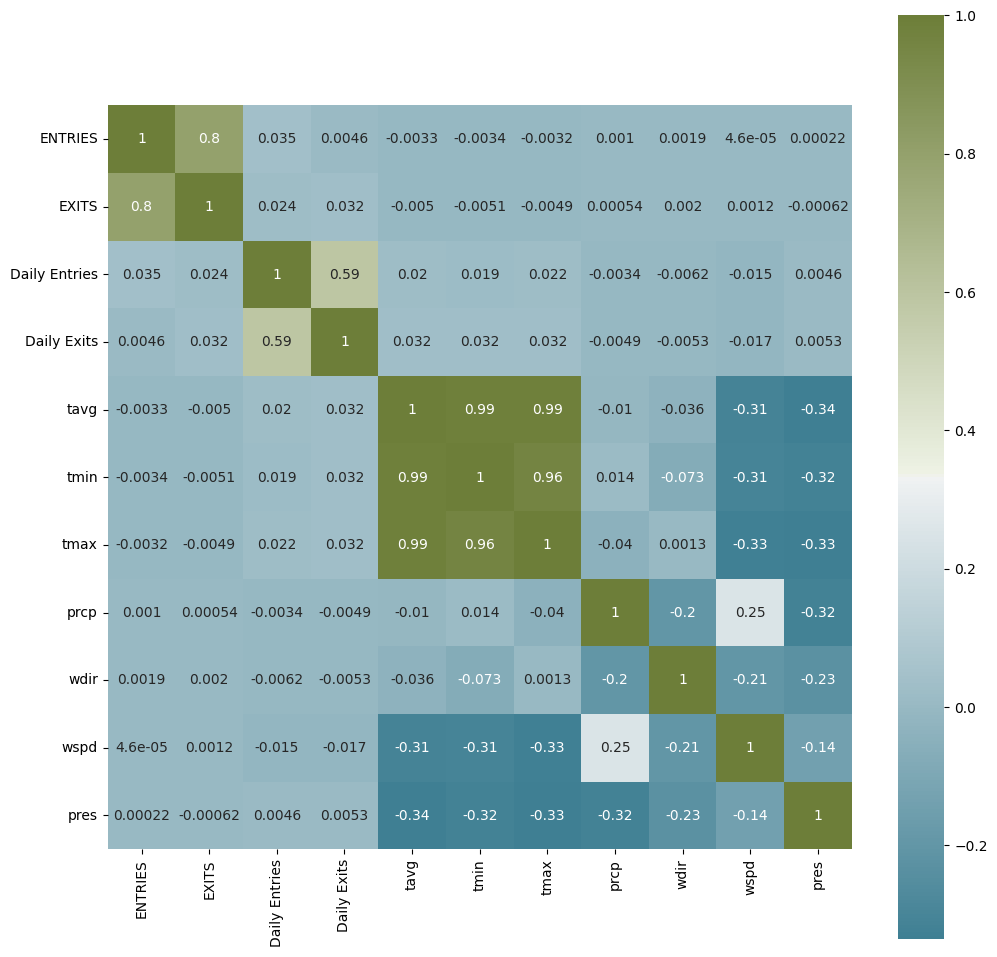

In [45]:
#Plotting heatmap to show correlation of turnstile data and weather data
# Set the width and height of the plot
f, ax = plt.subplots(figsize=(12, 12))

# Generate correlation matrix
corr = df_corr.corr()

# Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 100, as_cmap=True),
            square=True, annot=True, ax=ax)


In [46]:
#Goal of this code is to determine if there is statistically significant difference in Daily Entries.
#ANOVA(Analysis of Variance) test to compare means between multiple features.
from scipy import stats

# Loop through each categorical variable to perform the ANOVA test
for i in categorical_vars:
    try:
        print(f"Testing variable: {i}")

        # Group 'Daily Entries' based on each unique level of the categorical variable
        groups = [data['Daily Entries'][data[i] == level] for level in data[i].dropna().unique()]

        # Perform the ANOVA test
        f, p = stats.f_oneway(*groups)

        print(f"P-Value for {i}: {p:.5f}\n")

    except Exception as e:
        print(f"Could not perform ANOVA for {i}: {e}\n")


Testing variable: C/A
P-Value for C/A: 0.00000

Testing variable: Unit
P-Value for Unit: 0.00000

Testing variable: SCP
P-Value for SCP: 0.00000

Testing variable: Line Name
P-Value for Line Name: 0.00000

Testing variable: Division
P-Value for Division: 0.00000

Testing variable: Time
P-Value for Time: 0.00000

Testing variable: Description
P-Value for Description: 0.00055



Feature Scaling

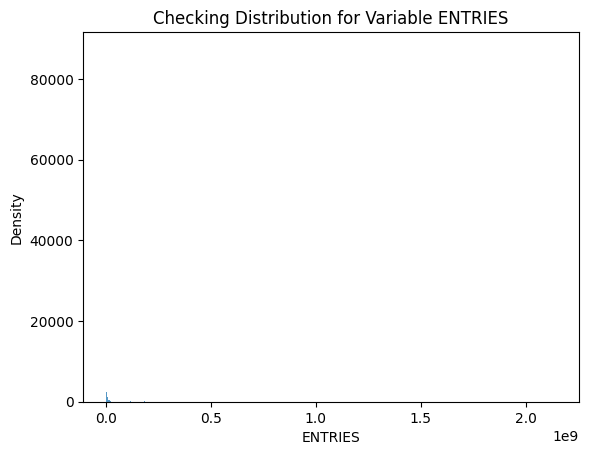

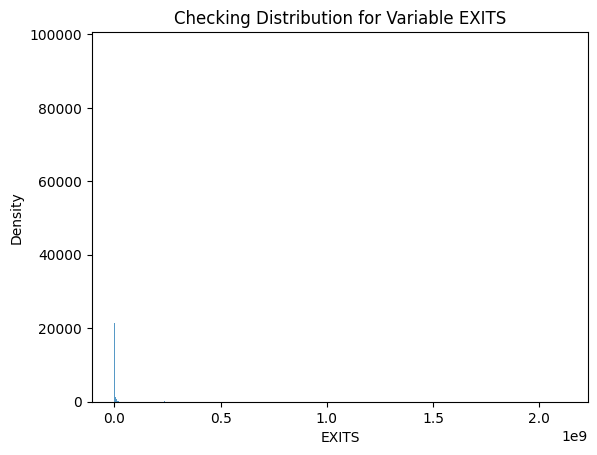

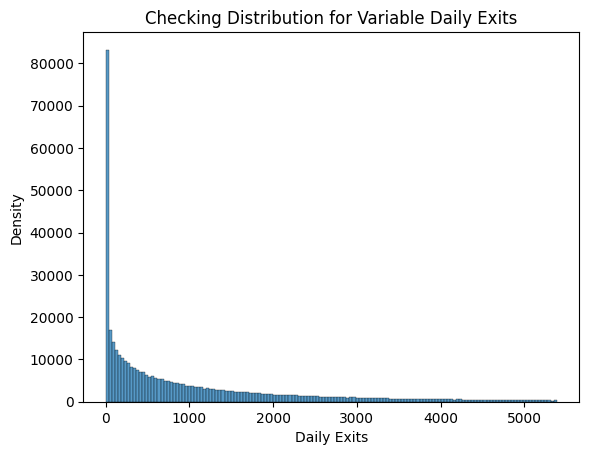

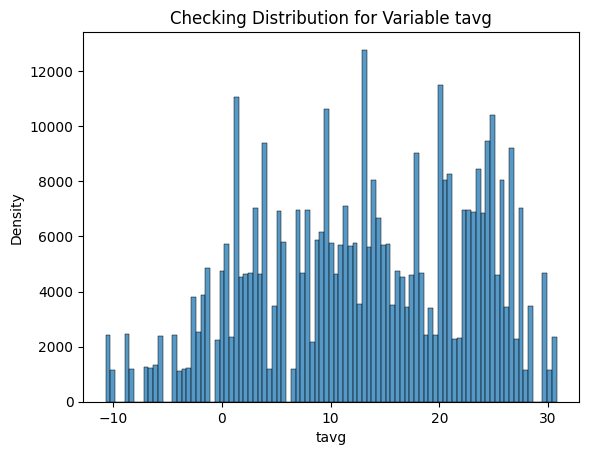

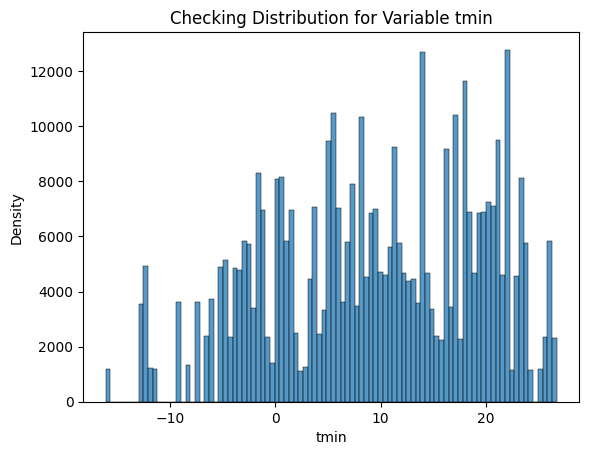

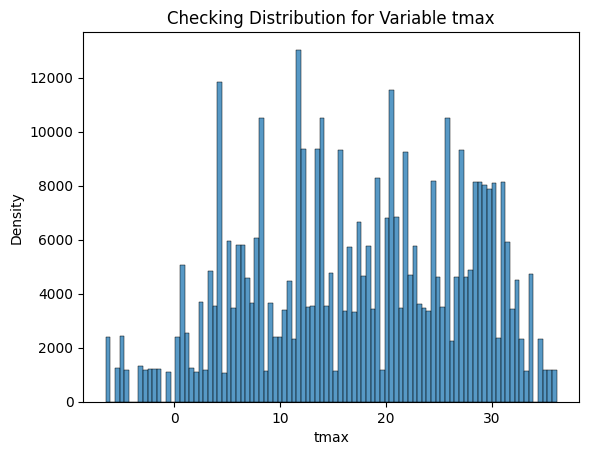

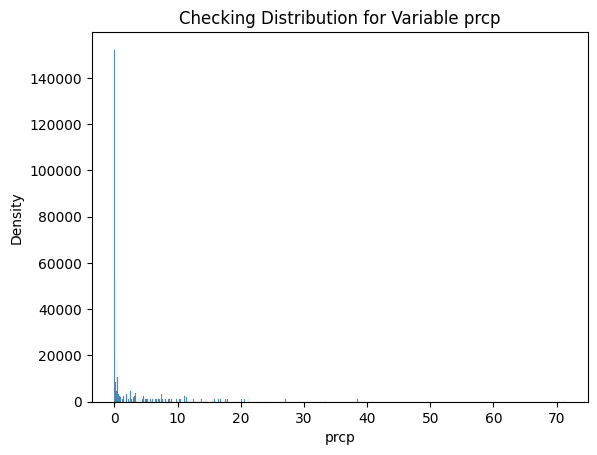

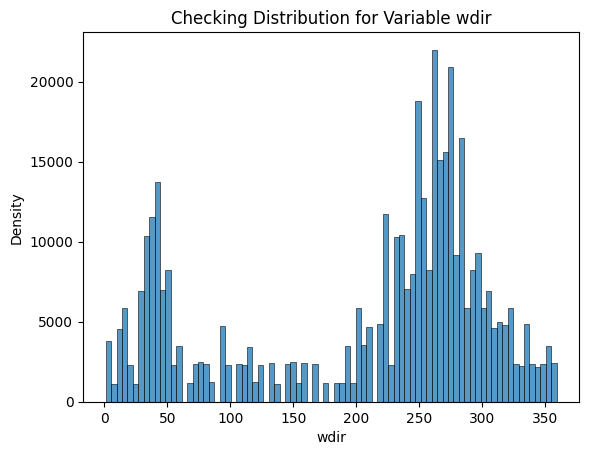

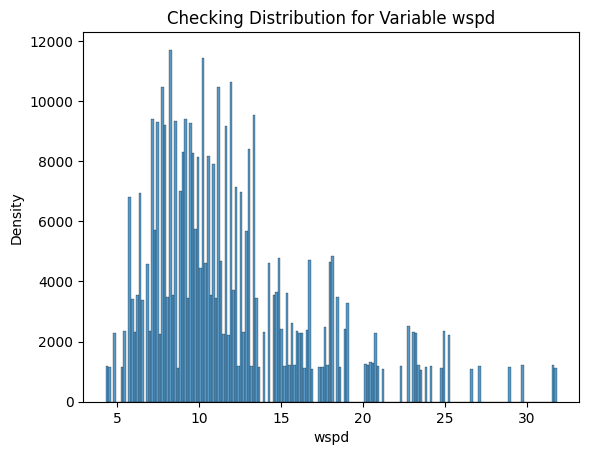

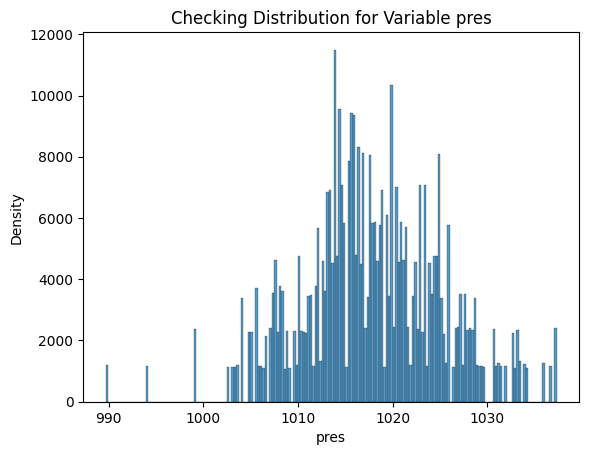

In [47]:
#The purpose of this code is to visualize the distributions of continuous variables to understand their characteristics.
# Checking if there is any normally distributed variable in data
for i in continuous_vars:
    if i == 'Daily Entries':
        continue
    sns.histplot(data[i],bins = 'auto')
    plt.title("Checking Distribution for Variable "+str(i))
    plt.ylabel("Density")
    plt.show()

# Standardization & Normalization

In [48]:
#Standardization scales the continuous variables so that they have Mean= 0 and Standard Deviation = 1, this ensure variables are on the same scale.
for i in continuous_vars:
    if i == 'Daily Entries':
        continue
    data[i] = (data[i] - data[i].mean())/data[i].std()

In [49]:
data.head(20)

,C/A,Unit,SCP,Line Name,Division,Date,Time,Description,ENTRIES,EXITS,Daily Entries,Daily Exits,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,A002,R051,02-00-00,NQR456W,BMT,2022-01-09,23:00:00,REGULAR,-0.118020,-0.125837,0.0,-0.819498,-1.201368,-1.407831,-1.245598,0.001904,0.182392,1.127598,0.725719
1,A002,R051,02-00-00,NQR456W,BMT,2022-01-11,15:00:00,REGULAR,-0.118018,-0.125831,330.0,-0.169723,-2.093965,-1.894849,-2.225415,-0.474514,1.273674,1.227897,1.827689
2,A002,R051,02-00-00,NQR456W,BMT,2022-01-14,07:00:00,REGULAR,-0.118013,-0.125823,753.0,0.047424,-1.221887,-1.570170,-1.205606,-0.474514,1.499795,2.451546,-1.083689
3,A002,R051,02-00-00,NQR456W,BMT,2022-01-19,11:00:00,REGULAR,-0.118006,-0.125811,1039.0,0.628977,-1.119290,-1.438270,-0.995645,-0.474514,-0.004404,0.967120,0.086304
4,A002,R051,02-00-00,NQR456W,BMT,2022-01-20,15:00:00,REGULAR,-0.118004,-0.125807,352.0,-0.406005,-1.365524,-1.712217,-1.325583,0.686756,1.067215,1.227897,0.521650
5,A002,R051,02-00-00,NQR456W,BMT,2022-01-21,23:00:00,REGULAR,-0.118001,-0.125803,476.0,-0.347766,-2.247862,-2.178943,-2.265407,-0.474514,-2.010004,1.649153,2.099781
6,A002,R051,02-00-00,NQR456W,BMT,2022-02-01,03:00:00,REGULAR,-0.117986,-0.125777,2357.0,2.100747,-1.683576,-2.199235,-1.305587,-0.474514,-1.695400,0.204847,2.208617
7,A002,R051,02-00-00,NQR456W,BMT,2022-02-02,11:00:00,REGULAR,-0.117984,-0.125772,329.0,-0.170555,-0.934614,-0.839643,-0.915660,-0.474514,-1.675737,-0.677785,1.746062
8,A002,R051,02-00-00,NQR456W,BMT,2022-02-10,07:00:00,REGULAR,-0.117970,-0.125749,2248.0,1.817042,-0.596043,-0.555550,-0.525733,-0.459626,0.605141,0.004249,-0.757180
9,A002,R051,02-00-00,NQR456W,BMT,2022-02-11,03:00:00,REGULAR,-0.117968,-0.125745,300.0,-0.401013,-0.503705,-1.073006,-0.415754,-0.474514,0.231549,-0.758024,-0.403461


In [50]:
#ML models can't process raw categorical variables or variables with different scales.
#One hot encoding for categorical variables (converts categorical variables into binary 0 or 1)
categorical_var=['Division','Description','C/A', 'Unit', 'SCP', 'Line Name']

In [51]:
# Get dummy variables for categorical variables
data = pd.get_dummies(data = data, columns = categorical_var)


In [52]:
data.iloc[:, data.columns != 'Daily Entries'].head()

,Date,Time,ENTRIES,EXITS,Daily Exits,tavg,tmin,tmax,prcp,wdir,...,Line Name_NQRW,Line Name_NQW,Line Name_NRW,Line Name_Q,Line Name_R,Line Name_R1W,Line Name_R2345,Line Name_RNW,Line Name_S,Line Name_S2345
0,2022-01-09,23:00:00,-0.118020,-0.125837,-0.819498,-1.201368,-1.407831,-1.245598,0.001904,0.182392,...,False,False,False,False,False,False,False,False,False,False
1,2022-01-11,15:00:00,-0.118018,-0.125831,-0.169723,-2.093965,-1.894849,-2.225415,-0.474514,1.273674,...,False,False,False,False,False,False,False,False,False,False
2,2022-01-14,07:00:00,-0.118013,-0.125823,0.047424,-1.221887,-1.570170,-1.205606,-0.474514,1.499795,...,False,False,False,False,False,False,False,False,False,False
3,2022-01-19,11:00:00,-0.118006,-0.125811,0.628977,-1.119290,-1.438270,-0.995645,-0.474514,-0.004404,...,False,False,False,False,False,False,False,False,False,False
4,2022-01-20,15:00:00,-0.118004,-0.125807,-0.406005,-1.365524,-1.712217,-1.325583,0.686756,1.067215,...,False,False,False,False,False,False,False,False,False,False


# Model Development Phase

In [53]:
#Import Libraries for decision tree
from sklearn import tree
import sklearn
from sklearn.metrics import accuracy_score
#import sklearn.cross_validation

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [54]:
#removing irrelevant columns 'Time' and 'Date' since they arent useful for modeling in their current form.
data=data.drop(['Time','Date'],axis=1)

In [55]:
#Defining X (features) and Y (target variable)
#X: all columns except 'Daily Entries'
#Y: The 'Daily Entries' column, representing subway ridership.
X = data.loc[:, data.columns != 'Daily Entries']
y = data['Daily Entries']

#Split the data
#Split the data into training (75%) and testing (25%) subsets for model training and evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Decision Tree Regressor

In [56]:
# Importing libraries for Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Building model on top of training dataset
fit_DT = DecisionTreeRegressor(max_depth = 2).fit(X_train,y_train)

# Calculating RMSE for training data to check for over fitting
pred_train = fit_DT.predict(X_train) #Predicts 'Daily Entries' for the training data.
rmse_for_train = np.sqrt(mean_squared_error(y_train,pred_train))

# Calculating RMSE for test data to check accuracy
t5=time.time()
pred_test = fit_DT.predict(X_test) #Predicts 'Daily Entries' for the test data.
t6=time.time()-t5
rmse_for_test =np.sqrt(mean_squared_error(y_test,pred_test))

print("RMSE For Train = "+str(rmse_for_train))
print("RMSE For Test = "+str(rmse_for_test))
print("time in second :::::::::::::::::::::::::::::::::::"+str(t6))
print("R^2 Score(coefficient of determination) = "+str(r2_score(y_test,pred_test)))

RMSE For Train = 732.7941602778453
RMSE For Test = 736.2431559434006
time in second :::::::::::::::::::::::::::::::::::0.5884313583374023
R^2 Score(coefficient of determination) = 0.3720211958585312


# Gradient Boosting Regressor

In [57]:
#An ensemble model that combines multiple weak learners (decision trees) to create a strong learner.
#Trees are built sequentially, and each tree focuses on reducing the residual error of the previous one.
# Importing library for GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor

# Building model on top of training dataset
fit_GB = GradientBoostingRegressor().fit(X_train, y_train)

# Calculating RMSE for training data to check for over fitting
pred_train = fit_GB.predict(X_train)
rmse_for_train = np.sqrt(mean_squared_error(y_train,pred_train))

# Calculating RMSE for test data to check accuracy
t3=time.time()
pred_test = fit_GB.predict(X_test)
t4=time.time()-t3
rmse_for_test =np.sqrt(mean_squared_error(y_test,pred_test))

print("RMSE IN TRAIN = "+str(rmse_for_train))
print("RMSE IN Test = "+str(rmse_for_test))
print("time in second :::::::::::::::::::::::::::::::::::"+str(t4))
print("R^2 Score(coefficient of determination) = "+str(r2_score(y_test,pred_test)))

RMSE IN TRAIN = 536.4850644631085
RMSE IN Test = 543.5678756003426
time in second :::::::::::::::::::::::::::::::::::2.5226519107818604
R^2 Score(coefficient of determination) = 0.6576975489313154


# Random Forest Regressor

In [58]:
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.metrics import mean_squared_error, r2_score

# Optimized RandomForest model
fit_RF = RandomForestRegressor(
    n_estimators=100,            # Reduced number of trees
    max_depth=10,                # Limit tree depth
    min_samples_split=10,        # Minimum samples to split
    min_samples_leaf=4,          # Minimum samples per leaf
    max_features='sqrt',         # Use sqrt of features at each split
    n_jobs=-1                    # Use all cores for parallel processing
).fit(X_train, y_train)

# Calculating RMSE for training data to check for overfitting
pred_train = fit_RF.predict(X_train)
rmse_for_train = np.sqrt(mean_squared_error(y_train, pred_train))

# Calculating RMSE for test data to check accuracy
t1 = time.time()
pred_test = fit_RF.predict(X_test)
t2 = time.time() - t1
rmse_for_test = np.sqrt(mean_squared_error(y_test, pred_test))

print("RMSE for Train =", rmse_for_train)
print("RMSE for Test =", rmse_for_test)
print("Time in seconds:", t2)
print("R^2 Score (coefficient of determination) =", r2_score(y_test, pred_test))


RMSE for Train = 834.9233110090056
RMSE for Test = 837.1388390653917
Time in seconds: 1.5719985961914062
R^2 Score (coefficient of determination) = 0.1881095608872786


Exploratory Data Analysis: Subway usage vs Weather and Time.

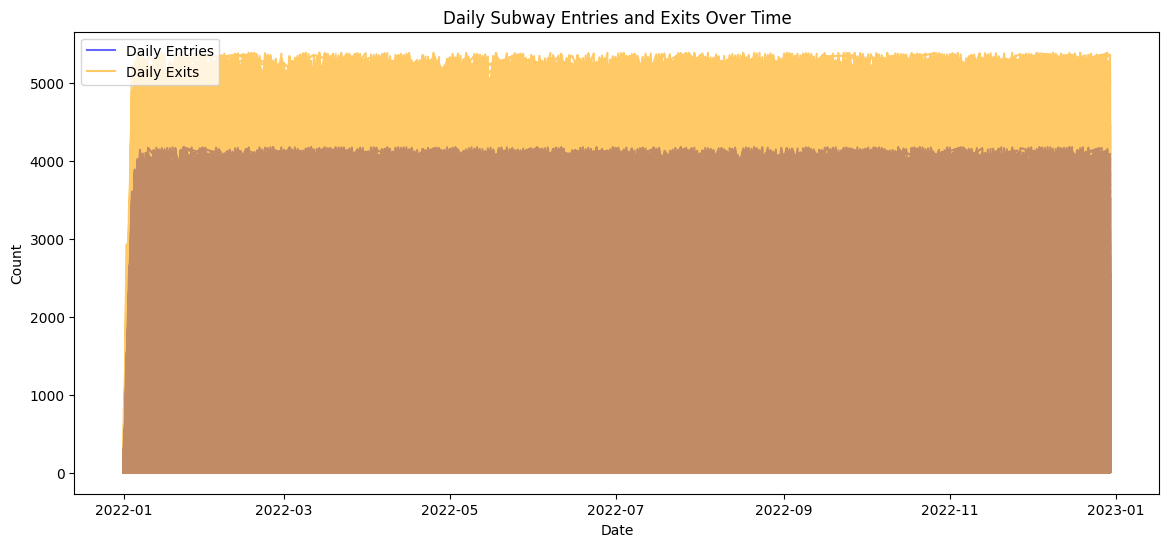

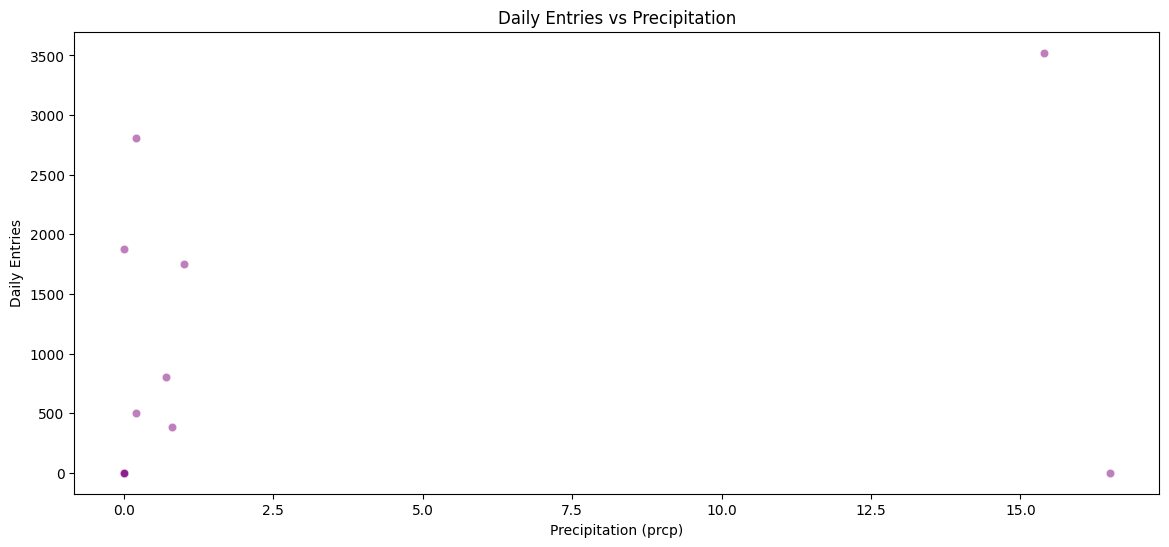

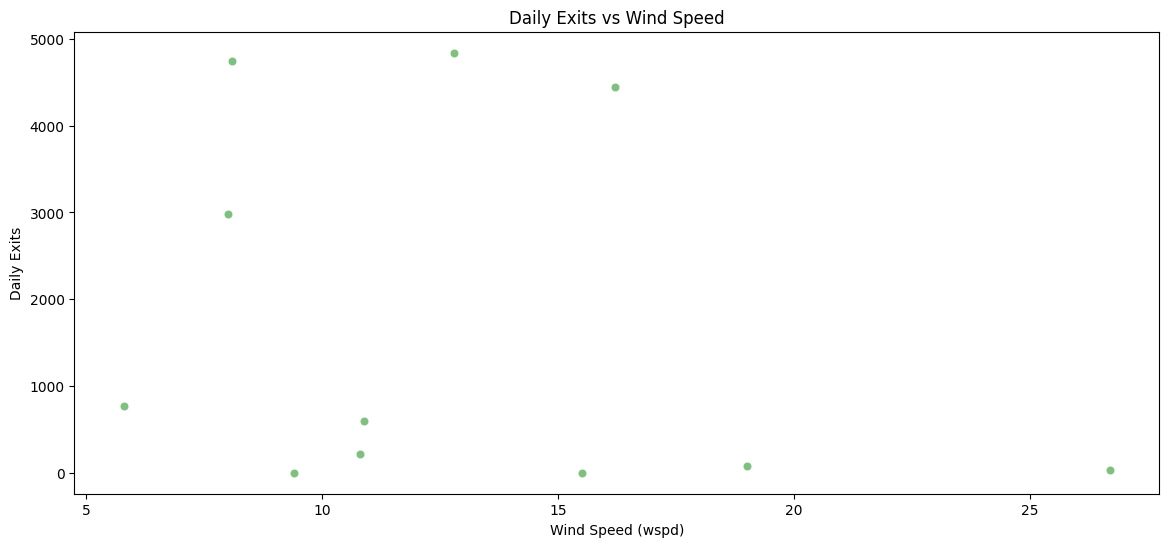

In [59]:

# Exploratory Data Analysis (EDA): Subway Usage vs Weather and Time

import seaborn as sns
import matplotlib.pyplot as plt

# Plot daily entries and exits over time to visualize general subway usage patterns
plt.figure(figsize=(14, 6))
plt.plot(turnstile_data['Date'], turnstile_data['Daily Entries'], label='Daily Entries', color='blue', alpha=0.6)
plt.plot(turnstile_data['Date'], turnstile_data['Daily Exits'], label='Daily Exits', color='orange', alpha=0.6)
plt.title('Daily Subway Entries and Exits Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Analyze impact of weather (precipitation and wind speed) on daily entries and exits
plt.figure(figsize=(14, 6))
sns.scatterplot(x=weather_data['prcp'], y=turnstile_data['Daily Entries'], color='purple', alpha=0.5)
plt.title('Daily Entries vs Precipitation')
plt.xlabel('Precipitation (prcp)')
plt.ylabel('Daily Entries')
plt.show()

plt.figure(figsize=(14, 6))
sns.scatterplot(x=weather_data['wspd'], y=turnstile_data['Daily Exits'], color='green', alpha=0.5)
plt.title('Daily Exits vs Wind Speed')
plt.xlabel('Wind Speed (wspd)')
plt.ylabel('Daily Exits')
plt.show()


<ipython-input-60-5dcb04fb7d5d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Rush Hour', y='Daily Entries', data=turnstile_data, palette='Set2')


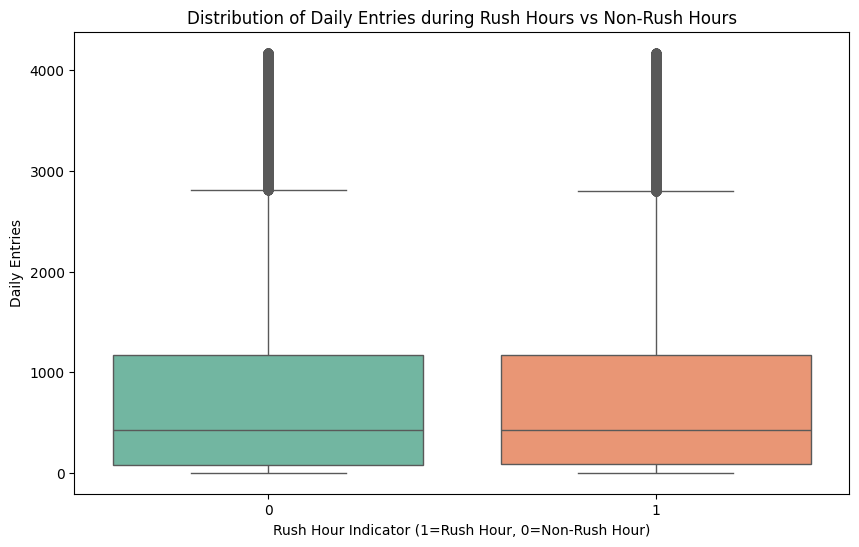

In [60]:
# Feature Engineering: Adding Rush Hour Indicator
#Rush hours are critical periods for subway usage, typically during the morning and evening commutes
# Define rush hours as morning (7-9 AM) and evening (4-7 PM) peak times
turnstile_data['Hour'] = turnstile_data['Time'].apply(lambda x: pd.to_datetime(x).hour)
turnstile_data['Rush Hour'] = turnstile_data['Hour'].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0)

# Visualize the difference in daily entries during rush hours and non-rush hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rush Hour', y='Daily Entries', data=turnstile_data, palette='Set2')
plt.title('Distribution of Daily Entries during Rush Hours vs Non-Rush Hours')
plt.xlabel('Rush Hour Indicator (1=Rush Hour, 0=Non-Rush Hour)')
plt.ylabel('Daily Entries')
plt.show()

#The box plot shows that subway ridership is generally higher during rush hours compared to non rush hours

Correlation Analysis between weather conditions and subway usage.

Correlation Matrix between Weather Conditions and Subway Usage:                Daily Entries  Daily Exits      prcp      wspd      tavg
Daily Entries       1.000000     0.591360  0.261481 -0.447084  0.563616
Daily Exits         0.591360     1.000000 -0.046468 -0.250141  0.543155
prcp                0.261481    -0.046468  1.000000  0.366612  0.017018
wspd               -0.447084    -0.250141  0.366612  1.000000 -0.396464
tavg                0.563616     0.543155  0.017018 -0.396464  1.000000


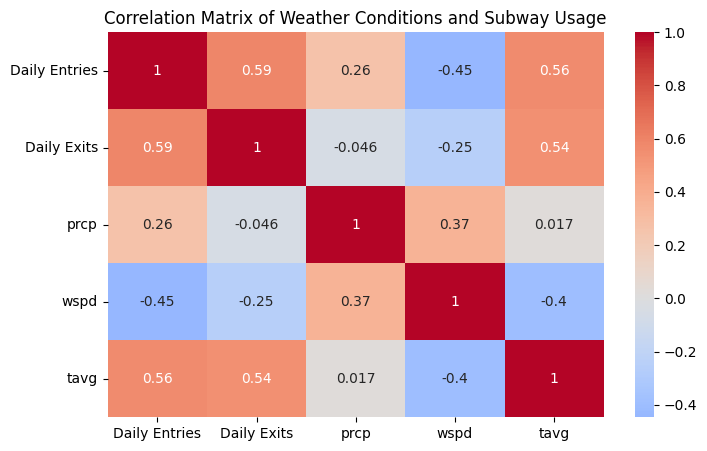

In [61]:
#This analysis explores the correlation between weather conditions and subway ridership patterns.
# Statistical Analysis: Correlation between Weather and Subway Usage

# Calculate correlation between daily entries/exits and weather conditions
weather_cols = ['prcp', 'wspd', 'tavg']
usage_cols = ['Daily Entries', 'Daily Exits']

correlations = turnstile_data[usage_cols].join(weather_data[weather_cols]).corr()
print("Correlation Matrix between Weather Conditions and Subway Usage:", correlations)

# Visualize correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Weather Conditions and Subway Usage')
plt.show()

#The heatmap shows that subway usage has positive relationship with temperature and precipitation, but a negative relationship with wind speed.
# Weather conditions can influence the subway usage.
# These insights could inform transit scheduling or resource allocations.

Log Transformation

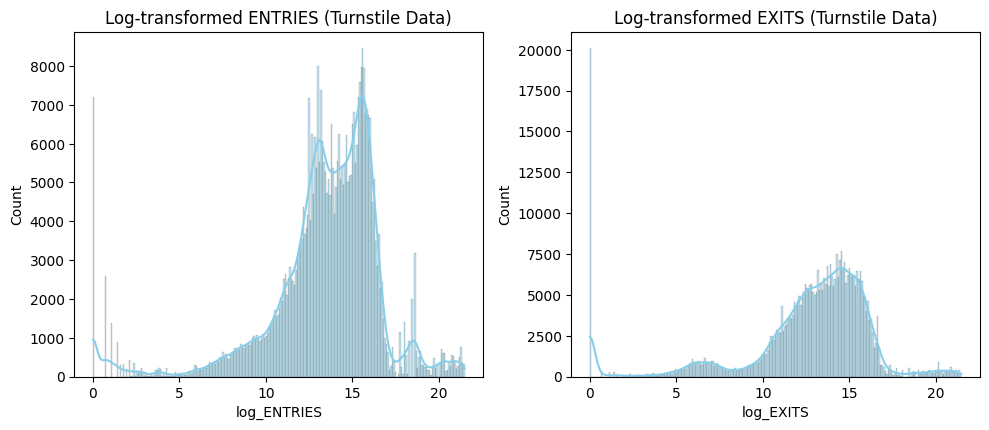

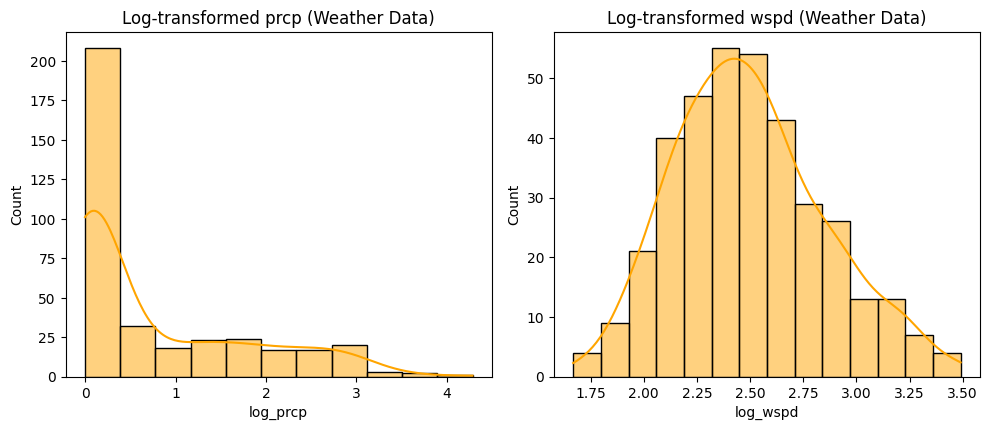

In [62]:
#Log transformation is used to reduce skewness and make the data more normally distributed, which is helpful for modeling and statistical analysis
#Log transformation compresses large values, making the data more normally distributed. This helps reliability on statistical analysis and model performances.

# Log transformation for turnstile_data
skewed_vars_turnstile = ['ENTRIES', 'EXITS']
for var in skewed_vars_turnstile:
    turnstile_data[f'log_{var}'] = np.log1p(turnstile_data[var])

# Log transformation for weather_data
skewed_vars_weather = ['prcp', 'wspd']
for var in skewed_vars_weather:
    weather_data[f'log_{var}'] = np.log1p(weather_data[var])

# Display histograms for transformed variables in turnstile_data
plt.figure(figsize=(10, 8))
for i, var in enumerate(skewed_vars_turnstile, 1):
    plt.subplot(2, 2, i)
    sns.histplot(turnstile_data[f'log_{var}'], kde=True, color='skyblue')
    plt.title(f'Log-transformed {var} (Turnstile Data)')
plt.tight_layout()
plt.show()

# Display histograms for transformed variables in weather_data
plt.figure(figsize=(10, 8))
for i, var in enumerate(skewed_vars_weather, 1):
    plt.subplot(2, 2, i)
    sns.histplot(weather_data[f'log_{var}'], kde=True, color='orange')
    plt.title(f'Log-transformed {var} (Weather Data)')
plt.tight_layout()
plt.show()


#After transformation the subway entries and exits are more evenly distributed. Similarly weather variables like prcp and wspd are less extreme improving analysis.

Hyperparameter Tuning for Random Forest

In [ ]:
# Hyperparameter Tuning for Random Forest Model
#Hyperparameter Tuning helps us optimize the Random Forest model by systematically testing different configurations of its parameter. We use GridSearchCV to find the best combination of parameters.

from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV to tune the model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(turnstile_data[usage_cols], turnstile_data['Daily Entries'])

# Print the best parameters and score
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best Score from Grid Search:", -grid_search.best_score_)

In [ ]:
#Importing additional libraries for metrics and cross-validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [ ]:
#Function to evaluate models with cross-validation
def evaluate_model(model, X, y):
    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1))
    cv_r2 = cross_val_score(model, X, y, scoring='r2', cv=kf, n_jobs=-1)

    print("Cross-Validation RMSE:", np.mean(cv_rmse))
    print("Cross-Validation R²:", np.mean(cv_r2))
    return np.mean(cv_rmse), np.mean(cv_r2)

In [ ]:
#Evaluate Random Forest model
print("Random Forest Evaluation:")
rf_rmse, rf_r2 = evaluate_model(fit_RF, X, y)

In [ ]:
#Evaluate Gradient Boosting model
print("Gradient Boosting Evaluation:")
gb_rmse, gb_r2 = evaluate_model(fit_GB, X, y)

In [ ]:
#Residual Analysis for Gradient Boosting
print("Residual Analysis for Gradient Boosting Model:")
residuals = y_test - fit_GB.predict(X_test)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals of Gradient Boosting Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Feature Importance Analysis for Gradient Boosting
print("Feature Importance for Gradient Boosting Model:")
importances = fit_GB.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X.columns[indices][:10]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], importances[indices][:10][::-1], color='green')
plt.title('Top 10 Important Features - Gradient Boosting')
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
#Further Hyperparameter Tuning for Gradient Boosting
from sklearn.model_selection import RandomizedSearchCV

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(),
    param_distributions=param_grid_gb,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1
)

print("Performing Gradient Boosting Randomized Search...")
random_search_gb.fit(X_train, y_train)
print("Best Parameters for Gradient Boosting:", random_search_gb.best_params_)

In [ ]:
#Final Gradient Boosting model with optimized parameters
final_gb = GradientBoostingRegressor(**random_search_gb.best_params_).fit(X_train, y_train)
final_rmse = np.sqrt(mean_squared_error(y_test, final_gb.predict(X_test)))
final_r2 = r2_score(y_test, final_gb.predict(X_test))

print("Final Gradient Boosting RMSE:", final_rmse)
print("Final Gradient Boosting R²:", final_r2)

In [ ]:
#Compare model performances
models = ['Random Forest', 'Gradient Boosting', 'Final Gradient Boosting']
rmses = [rf_rmse, gb_rmse, final_rmse]
r2_scores = [rf_r2, gb_r2, final_r2]

plt.figure(figsize=(10, 6))
plt.bar(models, rmses, color='skyblue', label='RMSE')
plt.title('Model Performance Comparison')
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color='orange', label='R²')
plt.title('Model R² Comparison')
plt.ylabel('R²')
plt.show()